#  The normal model with pymc

##### Keywords: bayesian, normal-normal model, conjugate prior, MCMC engineering, pymc3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
import seaborn as sns

from scipy.stats import norm


 A random variable $Y$ is normally distributed with mean $\mu$ and variance $\sigma^2$. Thus its density is given by :
 
 $$ p(y \vert \mu, \sigma^2) =  \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{-( \frac{y-\mu}{2 \sigma})^2} $$
 
 
Suppose our model is $\{y_1, \ldots, y_n \vert \mu, \sigma^2 \} \sim N(\mu, \sigma^2)$ then
the likelihood is 

$$
p(y_1, \ldots, y_n \vert \mu, \sigma^2) = 
\prod_{i=1}^{n} p(y_i \vert \mu, \sigma^2)=\prod_{i=1}^{n}  \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{-( \frac{(y_i-\mu)^2}{2\sigma^2})} = 
\frac{1}{ \sqrt{ 2 \pi \sigma^2}}   \exp \left\{  - \frac{1}{2}  \sum_i \frac{(y_i-\mu)^2}{\sigma^2} \right\} 
$$

We can now write the posterior for this model thus:

$$ p( \mu, \sigma^2 \vert  y_1, \ldots, y_n, \sigma^2)  \propto \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{ - \frac{1}{2\sigma^2} \sum (y_i - \mu)^2 } \, p(\mu, \sigma^2)$$

Lets see the posterior of $\mu$ assuming we 
know $\sigma^2$.  

## Normal Model for fixed $\sigma$

Now we wish to condition on a known $\sigma^2$. The prior probability distribution for it can then be written as:

$$p(\sigma^2) = \delta(\sigma^2 -\sigma_0^2)$$

(which does integrate to 1).

Now, keeping in mind that $p(\mu, \sigma^2) = p(\mu \vert \sigma^2) p(\sigma^2)$ and carrying out the integral over $\sigma^2$ which because of the delta distribution means that we must just substitute $\sigma_0^2$ in, we get:

$$ p( \mu \vert  y_1, \ldots, y_n, \sigma^2 = \sigma_0^2)  \propto p(\mu \vert \sigma^2=\sigma_0^2) \,e^{ - \frac{1}{2\sigma_0^2} \sum (y_i - \mu)^2 }$$

where I have dropped the $\frac{1}{\sqrt{2\pi\sigma_0^2}}$ factor as there is no stochasticity in it (its fixed).


Say we have the prior

$$ p(\mu \vert \sigma^2) = \exp \left\{ -\frac{1}{2 \tau^2} (\hat{\mu}-\mu)^2 \right\} $$



## Example of the normal model for fixed $\sigma$

We have data on the wing length in millimeters of a nine members of a particular species of moth. We wish to make inferences from those measurements on the population mean $\mu$. Other studies show the wing length to be around 19 mm. We also know that the length must be positive. We can choose a prior that is normal and most of the density is above zero ($\mu=19.5,\tau=10$). This is only a **marginally informative** prior.

Many bayesians would prefer you choose relatively uninformative (and thus weakly regularizing) priors. This keeps the posterior in-line (it really does help a sampler remain in important regions), but does not add too much information into the problem.

The measurements were: 16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8 giving $\bar{y}=18.14$. 

In [2]:
Y = [16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8]
#Data Quantities
sig = np.std(Y) # assume that is the value of KNOWN sigma (in the likelihood)
mu_data = np.mean(Y)
n = len(Y)
print("sigma", sig, "mu", mu_data, "n", n)

sigma 1.3309237486390264 mu 18.144444444444446 n 9


In [3]:
# Prior mean
mu_prior = 19.5
# prior std
std_prior = 10 

## Sampling by  code

We now set up code to do metropolis using logs of distributions:

In [5]:
import tqdm
def metropolis(logp, qdraw, stepsize, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    accepted = 0
    for i in tqdm.tqdm(range(nsamp)):
        x_star = qdraw(x_prev, stepsize)
        logp_star = logp(x_star)
        logp_prev = logp(x_prev)
        logpdfratio = logp_star -logp_prev
        u = np.random.uniform()
        if np.log(u) <= logpdfratio:
            samples[i] = x_star
            x_prev = x_star
            accepted += 1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted


In [6]:
def prop(x, step):
    return np.random.normal(x, step)

Remember, that up to normalization, the posterior is the likelihood times the prior. Thus the log of the posterior is the sum of the logs of the likelihood and the prior. 

In [7]:
logprior = lambda mu: norm.logpdf(mu, loc=mu_prior, scale=std_prior)
loglike = lambda mu: np.sum(norm.logpdf(Y, loc=mu, scale=np.std(Y)))
logpost = lambda mu: loglike(mu) + logprior(mu)

Now we sample:

In [8]:
x0=np.random.uniform()
nsamps=100000
samps, acc = metropolis(logpost, prop, 1, nsamps, x0)

100%|██████████| 100000/100000 [00:39<00:00, 2549.23it/s]


The acceptance rate is reasonable. You should shoot for somewhere between 20 and 50%.

In [9]:
acc/nsamps

0.46166

appropriately thinned, we lose any correlation..

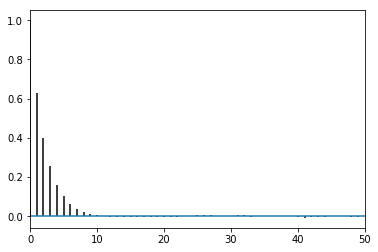

In [10]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
corrplot(samps[40000::]);

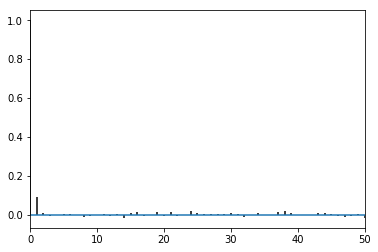

In [11]:
corrplot(samps[40000::5]);

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


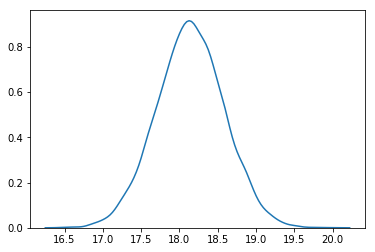

In [12]:
sns.kdeplot(samps[40000::5]);

## Sampling with pymc

We'll use this simple example to show how to sample with pymc. To install pymc3, do

`conda install -c conda-forge pymc3`.

We want  `pymc 3.5`.

Pymc3 is basically a sampler which uses NUTS for continuous variables and Metropolis for discrete ones, but we can force it to use Metropolis for all, which is what we shall do for now.

pymc3 docs are available [here](https://pymc-devs.github.io/pymc3/). 

The structure is that we define a model within a context manager, and optionally do the sampling there. The model name (`model1` below) and trace name (`model1trace` below) are both important names you should keep track of.

The context manager below makes it look as if the variables defined under it do not survive outside the scope of the manager. This is not true, and can be the cause of subtle bugs when comparing models. I would wrap models in functions if you want to keep the variables private.

In [20]:
import pymc3 as pm
with pm.Model() as model1:
    mu = pm.Normal('mu', mu=mu_prior, sd=std_prior)#parameter's prior
    wingspan = pm.Normal('wingspan', mu=mu, sd=np.std(Y), observed=Y)#likelihood
    #stepper=pm.Metropolis(tune_interval=1000)
    tracemodel1=pm.sample(100000)#, step=stepper)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 201000/201000 [00:47<00:00, 4237.81draws/s]
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


See https://docs.pymc.io/api/inference.html#step-methods for details.

Notice that `wingspan`, which is the  data, is defined using the same exact notation as the  prior abovem with the addition of the `observed` argument. This is because Bayesian notation does not distinguish between data d=and parameter nodes..everything is treated equally, and all the action is in taking conditionals and marginals of distributions.

Deterministics are deterministic functions of variables:

In [21]:
model1.deterministics

[]

The variables:

In [22]:
model1.vars, model1.named_vars, type(model1.mu)

([mu], {'mu': mu, 'wingspan': wingspan}, pymc3.model.FreeRV)

The "Observed" Variables, or data.

In [23]:
model1.observed_RVs, type(model1.wingspan)

([wingspan], pymc3.model.ObservedRV)

You can sample from stochastics. This is the generative nature of things...

In [26]:
model1.mu.random(size=10)

array([22.42816077, 18.18231437,  5.14962831, 30.10915054, 12.21606925,
       20.32883679, 31.94844628, 22.46582237, 18.58784441, 26.35527546])

And key for metropolis or other sampling algorithms, you must be able to get a log-probability for anything that has a distribution

In [27]:
model1.mu.logp({mu: '20'})

array(-3.22277363)

### Results

Pymc3 gives us a nice summary of our trace

In [28]:
pm.summary(tracemodel1[50000::])

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,18.14472,0.444351,0.002071,17.267537,19.0074,39912.614346,1.000035


The highest-posterior-density  is the  smallest width interval containing a pre-specified density amount. Here the default is the smallest width containing 95% of the density. Such an interval is called a **Bayesian Credible Interval**.

In [29]:
pm.hpd(tracemodel1[50000::])#pm.hpd(tracemodel1, alpha=0.05)

{0: {'mu': array([17.27375171, 19.00362361])},
 1: {'mu': array([17.27007825, 19.01707701])}}

You can also get quantiles:

In [30]:
pm.quantiles(tracemodel1[50000::])

{0: {'mu': {2.5: 17.276246768424585,
   25: 17.844791728029524,
   50: 18.140054887852532,
   75: 18.440008839680555,
   97.5: 19.007745806258907}},
 1: {'mu': {2.5: 17.27020570508063,
   25: 17.845172159247703,
   50: 18.148705108744572,
   75: 18.449650144692594,
   97.5: 19.017605502424097}}}

`pm.traceplot` will give you marginal posteriors and traces for all the "stochastics" in your model (ie non-data). It can even give you traces for some deterministic functions of stochastics..we shall see an example of this soon.

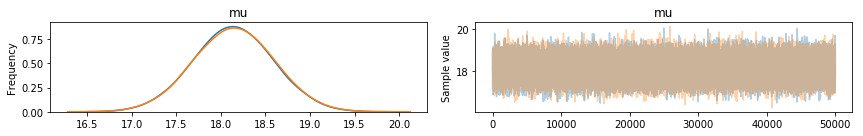

In [31]:
pm.traceplot(tracemodel1[50000::]);

Autocorrelation is easily accessible as well.

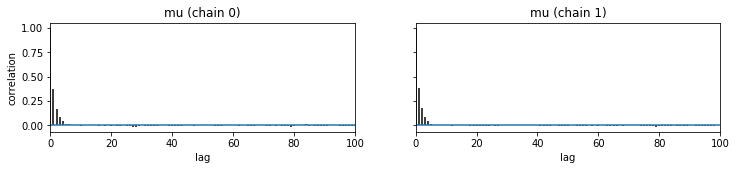

In [32]:
pm.autocorrplot(tracemodel1[50000::]);

Here we plot the results of our sampling against our manual sampler and see that all three match well.

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


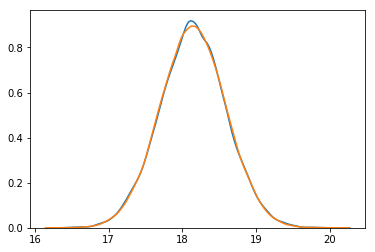

In [33]:
sns.kdeplot(samps[50000::]);
sns.kdeplot(tracemodel1[50000::]['mu']);

The **posterior predictive** is accessed via the `sample_ppc` function, which takes the trace, the number of samples wanted, and the model as arguments. The sampler will use the posterior traces and the defined likelihood to return samples from the posterior predictive.

In [34]:
tr1 = tracemodel1[50000::]
postpred = pm.sample_ppc(tr1, samples=1000, model=model1)

100%|██████████| 1000/1000 [00:00<00:00, 4026.87it/s]


In [35]:
postpred['wingspan'].shape

(1000, 9)

The posterior predictive will return samples for all data in the model's  `observed_RVs`. Its shape is by default the trace size times the data size in pymc3.5 (3.4 would give you a posterior-predictive the size of the posterior, our usual notion. 3.5 gives you the entire replicative posterior predictive. Also, 3.5 docs claim the API is sample_posterior_predictive, but this change has not yet been made, its still sample_ppc)

In [36]:
model1.observed_RVs

[wingspan]

To pull out just one posterior-predictive replicate:

In [37]:
ppc = postpred['wingspan'][:,0]

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


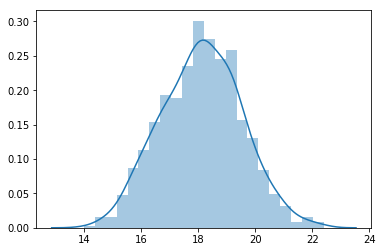

In [38]:
sns.distplot(ppc)

We plot the posterior predictive against the posterior to see how it is spread out! When we compare the posterior predictive to the posterior (unlike in the beta-binomial distribution where one is a rate and one is a count, here both are on the same scale), we find that the posterior predictive is smeared out due to the additional uncertainty from the sampling distribution.

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


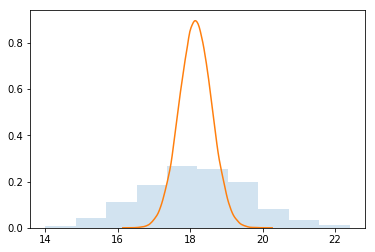

In [39]:
plt.hist(ppc, alpha=0.2, normed=True)
sns.kdeplot(tr1['mu']);

## Letting $\sigma$ be a stochastic

In [40]:
with pm.Model() as model12:
    mu = pm.Normal('mu', mu=mu_prior, sd=std_prior)#parameter's prior
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    wingspan = pm.Normal('wingspan', mu=mu, sd=sigma, observed=Y)#likelihood
    stepper=pm.Metropolis()
    tracemodel2=pm.sample(100000, step=stepper)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 201000/201000 [00:32<00:00, 6145.40draws/s]
/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


Few things to notice:

- the model being implemented is simply:

$$
h \sim N(\mu, \sigma)\\
\mu \sim Normal(\mu_{prior}, \sigma_{prior})\\
\sigma \sim Unif(0, 10)
$$

- we dont have to write log probs or even a proposal. A normal is standardly used.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26c5dac8>,
      dtype=object)

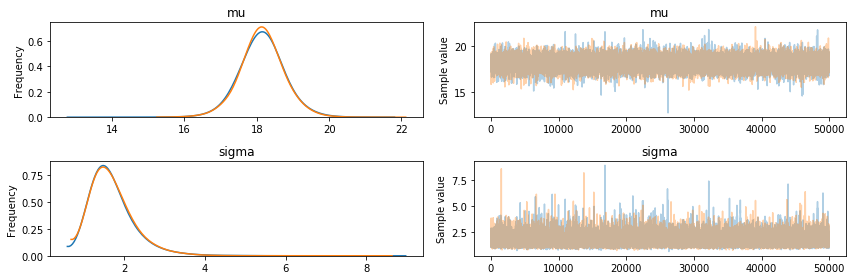

In [41]:
pm.traceplot(tracemodel2[50000::])

In [42]:
pm.summary(tracemodel2[50000::])

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,18.147115,0.593571,0.003986,16.980122,19.364086,19538.433764,1.000017
sigma,1.700446,0.542576,0.004414,0.881100,2.750127,14092.454909,1.000047


In [43]:
model12.vars

[mu, sigma_interval__]

In [44]:
model12.mu.logp(dict(mu=20, sigma_interval__=1))

array(-3.22277363)

In [45]:
model12.sigma_interval__.logp(dict(mu=20, sigma_interval__=1))

array(-1.62652338)